# Analysis on Sales of All Spring Summer Collections

collaboration between florianst and hj1901 for Oxford Strategy Group Digital, 2020

All data in this file has been anonymised.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
import math
import os
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from random import seed
from random import randint
from xgboost import XGBRegressor
from xgboost import plot_importance

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
seed(1)
warnings.filterwarnings('ignore')

C:\Users\Florian\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Creating the file for season sales with shop and product information

In [ ]:
# select related features
col = [...
       ]
dfs = pd.DataFrame(columns=col)
dic = {...
      }

dtype_dic = {'price': 'float', 'category': 'int16', 'city': 'int16', 'collection': 'int16',
             'franchising': 'int16', 'gender': 'int16', 'item': 'int16', 'outlet': 'int16',
             'period': 'int16', 'rotation': 'int16', 'seasonality': 'int16', 'store': 'int16',
             'store type': 'int16', 'volume': 'int16', 'zip': 'int16', 'income':'float'}

dfs.rename(columns=dic,inplace=True)
dfs = dfs.astype(dtype_dic)
product = pd.read_csv('data/20200120_barcode.csv')
store = pd.read_csv('data/20200120_filiali.csv')
product.rename(columns=dic,inplace=True)
store.rename(columns=dic,inplace=True)

# begin with spring summer season 
chunksize = 5000000

for df in pd.read_csv('sales_17.csv', chunksize=chunksize):

    df = df[df['Stagione'].astype('str')=='PE'][col]
    df = df.rename(columns=dic)
    df['gender'] = df['gender'].fillna(' ')
    product['gender'] = product['gender'].fillna(' ')
    for co in ['item', 'category', 'gender', 'collection']:
        le = LabelEncoder()
        le = le.fit(product[co].unique())
        df[co] = le.transform(df[co])
        prediction_test = pd.DataFrame(data=17, columns=['item'])
        print(le.inverse_transform(prediction_test))
        exit()
        
    # encoding features which could be ordinal
    period_map = {'M1':1, 'M2':2, ' ':8, 'M3':3, 'M0':0, 'M4':4, 'M5':5, 'M6':6, 'M7':7}
    seasonality_map = {'NC':0, 'LE':1, 'MP':2, 'PE':3}
    df['period'] = df['period'].map(period_map)
    df['seasonality'] = df['seasonality'].map(seasonality_map)
    le = LabelEncoder()
    le = le.fit(df['rotation'].unique())
    df['rotation'] = le.transform(df['rotation'])
    
    df['zip'] = df['zip'].astype('str')
    df['zip'] = df['zip'].apply(lambda x: '{0:0>5}'.format(x) if x!=' ' else x)
    df['outlet'] = df['outlet'].fillna(' ')
    store['outlet'] = store['outlet'].fillna(' ')
    for co in ['franchising','store type','outlet','zip','city', 'store']:
        le = LabelEncoder()
        le = le.fit(store[co].unique())
        df[co] = le.transform(df[co])
    
    # convert to save memory
    for co in ['category', 'city', 'collection', 'franchising', 'gender', 'item', 'outlet', 'period', 'rotation', 'seasonality', 'store', 'store type', 'volume', 'zip']:
        df[co] = df[co].astype('int16')
    df['income'] = df['income'].astype('float')
    df['price'] = df['price'].astype('float')
    
    dfs = dfs.append(df)
       
    print('-', end=' ')

dfs.to_csv('sales_17_encoded.csv', sep=',', header=True, index=False)
del dfs

# Creating files with encoded features from both product and store

2017

In [ ]:
df = pd.read_csv('sales_17_encoded.csv')

Anomalies x 2,  income < -1000 with volume = -1 (adjustment in the balance sheet?)

In [5]:
#convert to datetime
def to_datetime(d):
    dates = {date:pd.to_datetime(str(date), format='%Y%m%d') for date in d.unique()}
    return d.map(dates)
df['date'] = to_datetime(df['date'])
df = df.sort_values(by = 'date')
df = df.set_index('date')
df = df['2017-01-30':'2017-09-03']
df = df.reset_index()
df['week'] = df['date'].apply(lambda x:x.week)
df['week'] = df['week'].apply(lambda x:x-4)
store = df[['store','franchising','store type','outlet','zip','city']].drop_duplicates()
df = df[df.volume>0].groupby(['store','week','item','category','gender','period','rotation','seasonality','collection']).agg({'volume':'sum','income':'sum','price':'mean'})
df = df.reset_index()
df = pd.merge(df, store, on=['store'], how='left')
df['year'] = 1
for co in ['year','week', 'category', 'city', 'collection', 'franchising', 'gender', 'item', 'outlet', 'period', 'rotation', 'seasonality', 'store', 'store type', 'zip']:
        df[co] = df[co].astype('int16')

In [ ]:
df.to_csv('sales_17_grouped.csv', sep=',', header=True, index=False)

2018

In [ ]:
df = pd.read_csv('sales_1819_encoded.csv')

In [4]:
#convert to datetime
def to_datetime(d):
    dates = {date:pd.to_datetime(str(date), format='%Y%m%d') for date in d.unique()}
    return d.map(dates)
df['date'] = to_datetime(df['date'])
df = df.sort_values(by = 'date')
for co in ['category', 'city', 'collection', 'franchising', 'gender', 'item', 'outlet', 'period', 'rotation', 'seasonality', 'store', 'store type', 'zip']:
        df[co] = df[co].astype('int16')
df = df.set_index('date')
df = df['2018-01-29':'2018-09-02']
df = df.reset_index()
df['week'] = df['date'].apply(lambda x:x.week)
df['week'] = df['week'].apply(lambda x:x-4)
store = df[['store','franchising','store type','outlet','zip','city']].drop_duplicates()
df = df[df.volume>0].groupby(['store','week','item','category','gender','period','rotation','seasonality','collection']).agg({'volume':'sum','income':'sum','price':'mean'})
df = df.reset_index()
df = pd.merge(df, store, on=['store'], how='left')
df['year'] = 2
for co in ['year','week', 'category', 'city', 'collection', 'franchising', 'gender', 'item', 'outlet', 'period', 'rotation', 'seasonality', 'store', 'store type', 'zip']:
        df[co] = df[co].astype('int16')

In [ ]:
df.to_csv('sales_18_grouped.csv', sep=',', header=True, index=False)

-----------------------------------

# Feature Engineering

In [2]:
df17 = pd.read_csv('sales_17_grouped.csv')
df18 = pd.read_csv('sales_18_grouped.csv')
del df17['collection']
del df18['collection']

In [3]:
print(str(pd.to_datetime('2017/04/03').week-4),' ',
str(pd.to_datetime('2017/04/23').week-4))
df17['best_price_promo'] = df17['week'].apply(lambda x: 1 if (x>=10)&(x<=12) else 0)
df18['best_price_promo'] = 0

10   12


In [4]:
print(str(pd.to_datetime('2017/04/24').week-4),' ',
str(pd.to_datetime('2017/05/28').week-4))
df17['10gg_promo'] = df17['week'].apply(lambda x: 1 if (x>=13)&(x<=17) else 0)
print(str(pd.to_datetime('2018/04/09').week-4),' ',
str(pd.to_datetime('2018/05/20').week-4))
df18['10gg_promo'] = df18['week'].apply(lambda x: 1 if (x>=11)&(x<=16) else 0)

13   17
11   16


In [5]:
print(str(pd.to_datetime('2017/05/15').week-4),' ',
str(pd.to_datetime('2017/06/18').week-4))
df17['Primavera_promo'] = df17['week'].apply(lambda x: 1 if (x>=16)&(x<=20) else 0)
df18['Primavera_promo'] = 0

16   20


In [6]:
print(str(pd.to_datetime('2017/06/26').week-4),' ',
str(pd.to_datetime('2017/06/30').week-4))
df17['presales_promo'] = df17['week'].apply(lambda x: 1 if x==22 else 0)
df18['presales_promo'] = 0

22   22


In [7]:
print(str(pd.to_datetime('2017/07/03').week-4),' ',
str(pd.to_datetime('2017/09/03').week-4))
df17['eos'] = df17['week'].apply(lambda x: 1 if (x>=23)&(x<=31) else 0)
print(str(pd.to_datetime('2018/07/02').week-4),' ',
str(pd.to_datetime('2018/09/02').week-4))
df18['eos'] = df18['week'].apply(lambda x: 1 if (x>=23)&(x<=31) else 0)

23   31
23   31


In [8]:
print(str(pd.to_datetime('2018/02/26').week-4),' ',
str(pd.to_datetime('2018/04/01').week-4))
df18['Fidelity_promo'] = df18['week'].apply(lambda x: 1 if (x>=5)&(x<=9) else 0)
df17['Fidelity_promo'] = 0

5   9


In [9]:
print(str(pd.to_datetime('2018/03/19').week-4),' ',
str(pd.to_datetime('2018/04/08').week-4))
df18['3x2_promo'] = df18['week'].apply(lambda x: 1 if (x>=8)&(x<=10) else 0)
df17['3x2_promo'] = 0

8   10


In [10]:
print(str(pd.to_datetime('2018/05/28').week-4),' ',
str(pd.to_datetime('2018/07/01').week-4))
df18['vecanze_promo'] = df18['week'].apply(lambda x: 1 if (x>=18)&(x<=22) else 0)
df17['vecanze_promo'] = 0 

18   22


In [11]:
df17['discount'] = df17['income']/(df17['volume']*df17['price'])
df18['discount'] = df18['income']/(df18['volume']*df18['price'])
df17 = df17[df17['discount']<2]
df18 = df18[df18['discount']<3]

In [12]:
df17 = df17[(df17['outlet']==0)&(df17['store type']==0)]
df18 = df18[(df18['outlet']==0)&(df18['store type']==0)]
del df17['outlet'],df17['store type'],df18['outlet'],df18['store type']

In [13]:
for co in ['city','item', 'store', 'volume', 'zip']:
        df17[co] = df17[co].astype('int16')
        df18[co] = df18[co].astype('int16')
for co in ['week','category', 'period', 'rotation', 'seasonality', 'gender', 'franchising', 'year', '10gg_promo', 'best_price_promo', 'Primavera_promo', 'Primavera_promo', 'presales_promo', 'eos', 'Fidelity_promo', '3x2_promo', 'vecanze_promo']:
        df17[co] = df17[co].astype('int8')
        df18[co] = df18[co].astype('int8')

In [33]:
def lag_feature(df, lags, col):
    tmp = df[['store','week','item','category','gender','period','rotation','seasonality',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['store','week','item','category','gender','period','rotation', 'seasonality', col+'_lag_'+str(i)]
        shifted['week'] += i
        df = pd.merge(df, shifted, how='left')
    return df

In [16]:
df17 = lag_feature(df17, [1,2,3], 'volume')
df18 = lag_feature(df18, [1,2,3], 'volume')

In [17]:
for co in ['volume_lag_1','volume_lag_2','volume_lag_3']:
    df17[co].fillna(0,inplace=True)
    df18[co].fillna(0,inplace=True)
    df17[co] = df17[co].astype('int16')
    df18[co] = df18[co].astype('int16')

In [20]:
df18.shape

(2412993, 27)

In [21]:
df17.to_csv('sales_17_feature.csv', sep=',', header=True, index=False)
df18.to_csv('sales_18_feature.csv', sep=',', header=True, index=False)

In [34]:
df17 = pd.read_csv('sales_17_feature.csv')
df18 = pd.read_csv('sales_18_feature.csv')

In [35]:
df17['week2'] = df17['week'] 
df18['week2'] = df18['week']
df18.week = df18.week+31

In [38]:
df17 = df17.append(df18)
del df18
matrix = df17
matrix.shape

In [41]:
group = matrix.groupby(['item']).agg({'price': ['mean']})
group.columns = ['item_average_price']
group.reset_index(inplace=True)
    
matrix = pd.merge(matrix, group, on=['item'], how='left')
matrix['item_average_price'] = matrix['item_average_price'].astype(np.float16)

group = matrix.groupby(['week','item']).agg({'price': ['mean']})
group.columns = ['item_week_average_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['week','item'], how='left')
matrix['item_week_average_price'] = matrix['item_week_average_price'].astype(np.float16)

lags = [1,2,3]
matrix = lag_feature(matrix, lags, 'item_week_average_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['item_week_average_price_lag_'+str(i)] - matrix['item_average_price']) / matrix['item_average_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)


fetures_to_drop = ['item_average_price', 'item_week_average_price']
for i in lags:
    fetures_to_drop += ['delta_price_lag_'+str(i)]
    fetures_to_drop += ['item_week_average_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [42]:
matrix.shape

(3770263, 29)

In [43]:
grouper = ['week','store','category','item']
grouper_col = 'store_category_item_average_volume'

group = matrix.groupby(grouper).agg({'volume': ['mean']})
group.columns = [grouper_col]
group.reset_index(inplace=True)

group.week = group.week+1

matrix = pd.merge(matrix, group, on=grouper, how='left')
matrix[grouper_col] = matrix[grouper_col].astype(np.float16)

In [44]:
grouper = ['week','store','category']
grouper_col = 'store_category_average_volume'

group = matrix.groupby(grouper).agg({'volume': ['mean']})
group.columns = [grouper_col]
group.reset_index(inplace=True)

group.week = group.week+1

matrix = pd.merge(matrix, group, on=grouper, how='left')
matrix[grouper_col] = matrix[grouper_col].astype(np.float16)

In [45]:
grouper = ['week','store','gender']
grouper_col = 'store_gender_average_volume'

group = matrix.groupby(grouper).agg({'volume': ['mean']})
group.columns = [grouper_col]
group.reset_index(inplace=True)

group.week = group.week+1

matrix = pd.merge(matrix, group, on=grouper, how='left')
matrix[grouper_col] = matrix[grouper_col].astype(np.float16)

In [46]:
grouper = ['week','store']
grouper_col = 'store_average_volume'

group = matrix.groupby(grouper).agg({'volume': ['mean']})
group.columns = [grouper_col]
group.reset_index(inplace=True)

group.week = group.week+1

matrix = pd.merge(matrix, group, on=grouper, how='left')
matrix[grouper_col] = matrix[grouper_col].astype(np.float16)

In [47]:
grouper = ['week','category','item']
grouper_col = 'category_item_average_volume'

group = matrix.groupby(grouper).agg({'volume': ['mean']})
group.columns = [grouper_col]
group.reset_index(inplace=True)

group.week = group.week+1

matrix = pd.merge(matrix, group, on=grouper, how='left')
matrix[grouper_col] = matrix[grouper_col].astype(np.float16)

In [48]:
grouper = ['week','city','category','item']
grouper_col = 'city_category_item_average_volume'

group = matrix.groupby(grouper).agg({'volume': ['mean']})
group.columns = [grouper_col]
group.reset_index(inplace=True)

group.week = group.week+1

matrix = pd.merge(matrix, group, on=grouper, how='left')
matrix[grouper_col] = matrix[grouper_col].astype(np.float16)

In [49]:
grouper = ['week','city','category']
grouper_col = 'city_category_average_volume'

group = matrix.groupby(grouper).agg({'volume': ['mean']})
group.columns = [grouper_col]
group.reset_index(inplace=True)

group.week = group.week+1

matrix = pd.merge(matrix, group, on=grouper, how='left')
matrix[grouper_col] = matrix[grouper_col].astype(np.float16)

In [55]:
for co in ['city','item', 'store', 'volume', 'zip']:
        matrix[co] = matrix[co].astype('int16')
for co in ['week','category', 'period', 'rotation', 'seasonality', 'gender', 'franchising', 'year', '10gg_promo', 'best_price_promo', 'Primavera_promo', 'Primavera_promo', 'presales_promo', 'eos', 'Fidelity_promo', '3x2_promo', 'vecanze_promo']:
        matrix[co] = matrix[co].astype('int8')
for co in ['volume_lag_1','volume_lag_2','volume_lag_3','week2']:
    matrix[co] = matrix[co].astype('int16')

In [60]:
for co in ['store_category_item_average_volume',
       'store_category_average_volume', 'store_gender_average_volume',
       'store_average_volume', 'category_item_average_volume',
       'city_category_item_average_volume', 'city_category_average_volume']:
    matrix[co].fillna(0, inplace=True)

In [109]:
matrix.shape
matrix.to_csv('matrix.csv', sep=',', header=True, index=False)

# Model Training

In [4]:
import sys
sys.path += ['C:\\Program Files\\Python37\\lib\\site-packages']
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import shap
matrix = pd.read_csv('matrix.csv')
matrix.shape

C:\Users\Florian\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(3770263, 36)

# XGBoost
Generate week-resolution heatmap of SHAP-generated price elasticity measure (inverse of how important is Incasso for our prediction)

In [5]:
weeks = range(45, 61)
product_eans = sorted(dict(matrix['item'].value_counts()[:10])) # find item codes with the highest number of data points
print(product_eans)
columnNames = matrix.columns

elasticities = []
for weeknum in weeks:
    X_train = matrix[(matrix.week <= weeknum-1)&(matrix.week >= weeknum-4)].drop(['volume'], axis=1)
    Y_train = matrix[(matrix.week <= weeknum-1)&(matrix.week >= weeknum-4)]['volume']
    X_test = matrix[matrix.week == weeknum].drop(['volume'], axis=1)
    Y_test = matrix[matrix.week == weeknum]['volume']

    model = XGBRegressor(
        max_depth=10,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3, 
        #tree_method='gpu_hist',
        seed=42)

    model.fit(
        X_train, 
        Y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, Y_train), (X_test, Y_test)], 
        verbose=20, 
        early_stopping_rounds = 5)
    
    # explain model predictions using SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # for boolean features, only plot High (set Low to nan)
    high_mask = (X_test == 0)
    masked_shap_values = np.copy(shap_values) # need a deep copy here apparently
    masked_shap_values[high_mask] = np.nan
    
    # record elasticity values for a set of EANs
    product_elasticities = []
    for ean in product_eans:
        # calculate SHAP values relating to the specific article
        shap_product = masked_shap_values[matrix[matrix.week == weeknum]['item'] == ean]
        # one definition of elasticity: inverse mean value of feature importance of Incasso (high importance indicates low elasticity)
        elasticity = 1/np.nanmean(shap_product[:,columnNames.get_loc("income")])
        product_elasticities.append(elasticity)

    elasticities.append(product_elasticities)
    print(product_elasticities)
    del model

[14, 25, 30, 42, 47, 57, 75, 105, 116, 123]
[0]	validation_0-rmse:25.01413	validation_1-rmse:23.86623
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
Stopping. Best iteration:
[5]	validation_0-rmse:8.38278	validation_1-rmse:10.54418



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


[-1.2090638916135776, -0.6072100020535646, -1.591319778692069, -1.2833248248598168, -0.31019296834486104, -0.3975628905258075, -0.38910218071605013, 2.153924606291479, 0.7478661994238425, 0.2196372467298468]
[0]	validation_0-rmse:26.46276	validation_1-rmse:24.60165
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[20]	validation_0-rmse:5.47506	validation_1-rmse:5.57106
Stopping. Best iteration:
[28]	validation_0-rmse:5.20939	validation_1-rmse:5.41608

[-1.4903386401627812, -0.4794906838191626, -1.2551970451439418, -1.1190027457467338, -0.19880848688603725, -0.2618146371864195, -0.2722729979680325, 1.1563554862699286, 0.5107166622932974, 0.1404024068463741]
[0]	validation_0-rmse:27.10242	validation_1-rmse:22.90008
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[20]	valid

[0]	validation_0-rmse:21.27541	validation_1-rmse:16.74450
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[20]	validation_0-rmse:5.25477	validation_1-rmse:3.16604
[40]	validation_0-rmse:4.92966	validation_1-rmse:2.83473
[60]	validation_0-rmse:4.78848	validation_1-rmse:2.69182
Stopping. Best iteration:
[70]	validation_0-rmse:4.74085	validation_1-rmse:2.63920

[-0.3218916092838354, -0.38325941153932924, -1.6646923856361033, -1.2190340669023614, -0.19734193934014843, -0.23756832851245427, -0.24879355143484277, 1.7719954807673317, 0.4488563447035366, 0.1879387215411543]
[0]	validation_0-rmse:18.84923	validation_1-rmse:19.29800
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[20]	validation_0-rmse:4.28852	validation_1-rmse:5.85190
[40]	validation_0-rmse:3.83428	validation_1-

KeyboardInterrupt: 

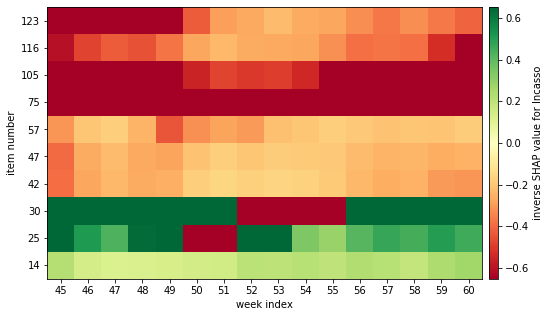

In [12]:
# plot heatmap
imscale = np.percentile(elasticities, 90)

plt.figure(figsize=(14,5))
heatmap = plt.imshow(np.column_stack(elasticities), cmap='RdYlGn', interpolation='nearest', 
                     extent=[-0.5, len(weeks)-0.5, -0.5, len(product_eans)-0.5], vmin=-imscale, vmax=imscale)
plt.xticks(range(len(weeks)), weeks)
plt.xlabel("week index")
plt.yticks(range(len(product_eans)), product_eans)
plt.ylabel("item number")

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='2%', pad=0.1)
cb = plt.gcf().colorbar(heatmap, cax=cax, orientation='vertical')
cb.ax.set_ylabel("inverse SHAP value for Incasso")

plt.show()

Now run xgboost model on whole spring/summer season

In [6]:
X_train = matrix[(matrix.week < 54)&(matrix.week > 3)].drop(['volume'], axis=1)
Y_train = matrix[(matrix.week < 54)&(matrix.week > 3)]['volume']
X_valid = matrix[(matrix.week < 61)&(matrix.week > 53)].drop(['volume'], axis=1)
Y_valid = matrix[(matrix.week < 61)&(matrix.week > 53)]['volume']
X_test = matrix[matrix.week > 60].drop(['volume'], axis=1)
Y_test = matrix[matrix.week > 60]['volume']

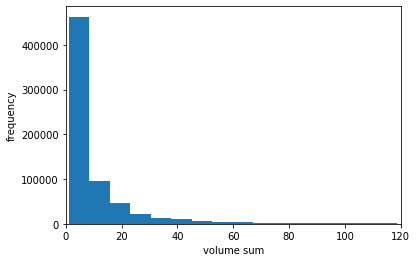

In [5]:
plt.hist(Y_valid, bins=200)
plt.xlim(0, 120)
plt.xlabel("volume sum")
plt.ylabel("frequency")
plt.show()

In [7]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 3)

[0]	validation_0-rmse:33.33403	validation_1-rmse:19.10328
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 3 rounds.
[1]	validation_0-rmse:24.15221	validation_1-rmse:13.72720
[2]	validation_0-rmse:17.96860	validation_1-rmse:10.51024
[3]	validation_0-rmse:13.73489	validation_1-rmse:8.30590
[4]	validation_0-rmse:10.68657	validation_1-rmse:6.60740
[5]	validation_0-rmse:8.75770	validation_1-rmse:5.62242
[6]	validation_0-rmse:7.54484	validation_1-rmse:5.15745
[7]	validation_0-rmse:6.80748	validation_1-rmse:4.90126
[8]	validation_0-rmse:6.32805	validation_1-rmse:4.79698
[9]	validation_0-rmse:6.01784	validation_1-rmse:4.69582
[10]	validation_0-rmse:5.59510	validation_1-rmse:4.47417
[11]	validation_0-rmse:5.38740	validation_1-rmse:4.43015
[12]	validation_0-rmse:5.26510	validation_1-rmse:4.39292
[13]	validation_0-rmse:5.09888	validation_1-rmse:4.17482
[14]	validation_0-rmse:4.99342	validation_1-rm

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=300, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [8]:
Y_pred = model.predict(X_test)
a = pd.DataFrame(np.array([list(Y_pred),list(Y_test)]).transpose(),columns=['volume sum','volume sum_pred'])
a['volume sum'] = a['volume sum'].round()
a['volume sum'] = a['volume sum'].astype('int16')
a['volume sum_pred'] = a['volume sum_pred'].astype('int16')
for i in range(0,5):
    a['success'] = (a['volume sum']- a['volume sum_pred']<=i)&(a['volume sum']- a['volume sum_pred']>=-i)
    c = a['success'].mean()
    print('prediction interval: +-',i,', sales prediction accuracy: ',c)

prediction interval: +- 0 , sales prediction accuracy:  0.7448806197978168
prediction interval: +- 1 , sales prediction accuracy:  0.9092192045159989
prediction interval: +- 2 , sales prediction accuracy:  0.9501526453731172
prediction interval: +- 3 , sales prediction accuracy:  0.9678364678436681
prediction interval: +- 4 , sales prediction accuracy:  0.9779672244463005


In [9]:
a

,volume sum,volume sum_pred,success
0,3,3,True
1,7,6,True
2,3,3,True
3,1,1,True
4,8,8,True
...,...,...,...
138879,2,2,True
138880,1,1,True
138881,1,1,True
138882,1,1,True


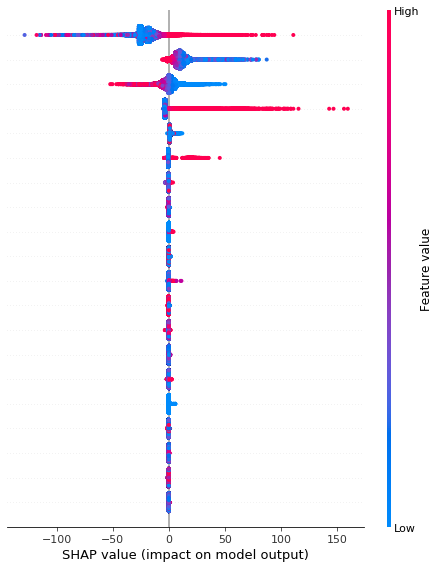

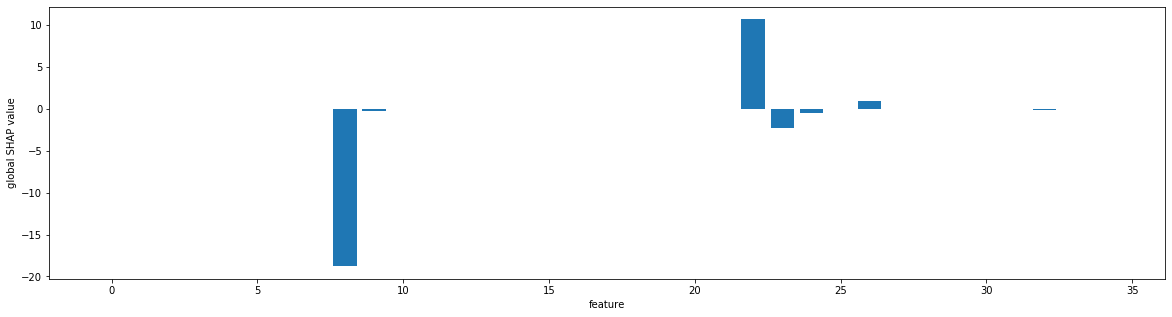

In [14]:
# visualise SHAP value averages across points in barplot
columnNames = matrix.columns
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=[""]*len(X_test)) # anonymise data

global_shap_values = np.nanmean(shap_values, axis=0) # average SHAP values across points

xvals = range(global_shap_values.shape[0])
plt.figure(figsize=(20,5))
plt.bar(xvals, global_shap_values)
#plt.xticks(xvals, columnNames, rotation='vertical')
plt.xlabel("feature")
plt.ylabel("global SHAP value")
plt.show()
plt.close()

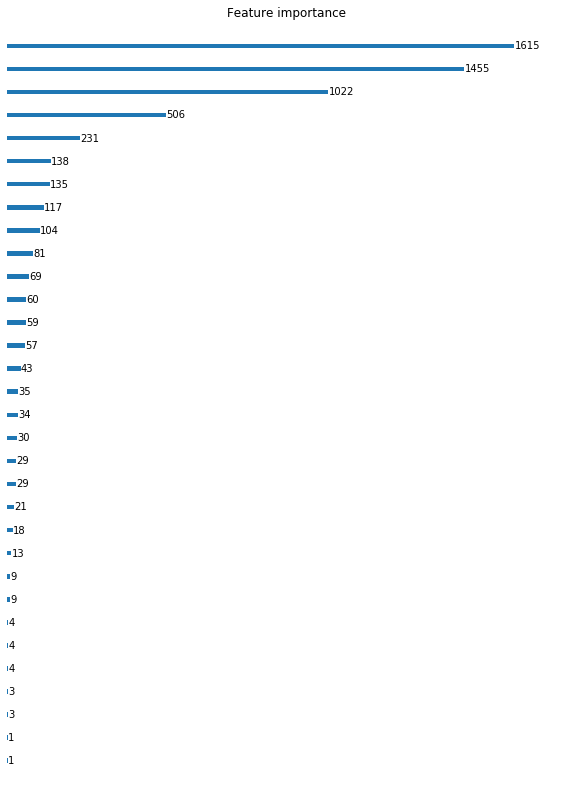

In [18]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    plt.axis('off') # anonymise data
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

# Lightgbm

In [4]:
import lightgbm as lgb
params = {
        'task' : 'train',
        'boosting_type' : 'gbdt',
        'objective' : 'regression',
        'metric' : {'l2'},
        'num_leaves' : 31,
        'learning_rate' : 0.1,
        'feature_fraction' : 0.9,
        'bagging_fraction' : 0.8,
        'bagging_freq': 5,
        'verbose' : 0
}
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

gbm = lgb.train(params,
            lgb_train,
            num_boost_round=500,
            valid_sets=lgb_valid,
            early_stopping_rounds=10)

[1]	valid_0's l2: 509.386
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 424.929
[3]	valid_0's l2: 356.752
[4]	valid_0's l2: 301.242
[5]	valid_0's l2: 258.634
[6]	valid_0's l2: 224.276
[7]	valid_0's l2: 194.657
[8]	valid_0's l2: 171.285
[9]	valid_0's l2: 151.825
[10]	valid_0's l2: 137.566
[11]	valid_0's l2: 125.217
[12]	valid_0's l2: 114.269
[13]	valid_0's l2: 104.472
[14]	valid_0's l2: 95.4811
[15]	valid_0's l2: 86.6446
[16]	valid_0's l2: 81.9073
[17]	valid_0's l2: 74.912
[18]	valid_0's l2: 70.4644
[19]	valid_0's l2: 67.106
[20]	valid_0's l2: 62.7421
[21]	valid_0's l2: 59.5477
[22]	valid_0's l2: 57.9918
[23]	valid_0's l2: 55.4183
[24]	valid_0's l2: 53.2151
[25]	valid_0's l2: 53.585
[26]	valid_0's l2: 51.3836
[27]	valid_0's l2: 49.8104
[28]	valid_0's l2: 48.7361
[29]	valid_0's l2: 47.2511
[30]	valid_0's l2: 46.4139
[31]	valid_0's l2: 45.6547
[32]	valid_0's l2: 45.3804
[33]	valid_0's l2: 44.1716
[34]	valid_0's l2: 44.223
[35]	valid_0's l2: 43.7657
[36]	va

In [6]:
Y_pred = gbm.predict(X_test)
a = pd.DataFrame(np.array([list(Y_pred),list(Y_test)]).transpose(),columns=['volume sum','volume sum_pred'])
a['volume sum'] = a['volume sum'].round()
a['volume sum'] = a['volume sum'].astype('int16')
a['volume sum_pred'] = a['volume sum_pred'].astype('int16')
for i in range(0,5):
    a['success'] = (a['volume sum']- a['volume sum_pred']<=i)&(a['volume sum']- a['volume sum_pred']>=-i)
    c = a['success'].mean()
    print('prediction interval: +-',i,', sales prediction accuracy: ',c)

prediction interval: +- 0 , sales prediction accuracy:  0.5199807033207569
prediction interval: +- 1 , sales prediction accuracy:  0.8639944126033237
prediction interval: +- 2 , sales prediction accuracy:  0.9407851156360704
prediction interval: +- 3 , sales prediction accuracy:  0.9680740762074825
prediction interval: +- 4 , sales prediction accuracy:  0.980213703522364


In [10]:
a.head(10)

,volume sum,volume sum_pred,success
0,2,3,True
1,6,6,True
2,4,3,True
3,1,1,True
4,8,8,True
5,2,2,True
6,18,17,True
7,4,3,True
8,2,1,True
9,4,4,True
